In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [58]:
mob = pd.read_csv(r"C:\Users\Terry\Downloads\Global_Mobility_Report.csv")
mob = mob[mob['country_region'] == 'United States']
truth = pd.read_csv(r"C:\LocalSrc\Shapelet_Ensemble\new_data\US_Case.csv").rename({'Unnamed: 0':'date'},axis=1).set_index('date')

C:\Users\Terry\AppData\Local\Temp\ipykernel_20324\3068248124.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  mob = pd.read_csv(r"C:\Users\Terry\Downloads\Global_Mobility_Report.csv")


In [59]:
mob = mob.groupby(['date','sub_region_1']).mean()

In [60]:
truth = truth.diff().stack().reset_index().rename({'level_1':'sub_region_1',0:'inc_case'},axis=1)
mob = mob['workplaces_percent_change_from_baseline'].reset_index()

In [68]:
df = pd.merge(truth,mob,on=['date','sub_region_1'],how='inner')

In [95]:
states = df['sub_region_1'].unique()
rslt = np.zeros(shape=(30,len(states)))
for i,state in enumerate(states):
    for j in range(30):
        curr_df = df[df['sub_region_1'] == state]
        curr_df['workplaces_percent_change_from_baseline'] = df['workplaces_percent_change_from_baseline'].shift(j)
        display(curr_df)
        curr_df = curr_df.dropna()
        rslt[j,i] = np.corrcoef(curr_df['inc_case'],curr_df['workplaces_percent_change_from_baseline'])[0,1]
        print(rslt[j,i])

C:\Users\Terry\AppData\Local\Temp\ipykernel_20324\3264105653.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df['workplaces_percent_change_from_baseline'] = df['workplaces_percent_change_from_baseline'].shift(j)


,date,sub_region_1,inc_case,workplaces_percent_change_from_baseline
0,2020-04-13,Alabama,203.0,-35.588235
51,2020-04-14,Alabama,171.0,-34.852941
102,2020-04-15,Alabama,266.0,-34.838235
153,2020-04-16,Alabama,158.0,-34.191176
204,2020-04-17,Alabama,92.0,-35.058824
...,...,...,...,...
46461,2022-10-11,Alabama,0.0,-10.352941
46512,2022-10-12,Alabama,0.0,-9.485294
46563,2022-10-13,Alabama,3015.0,-8.617647
46614,2022-10-14,Alabama,0.0,-8.897059


RuntimeError: No active exception to reraise

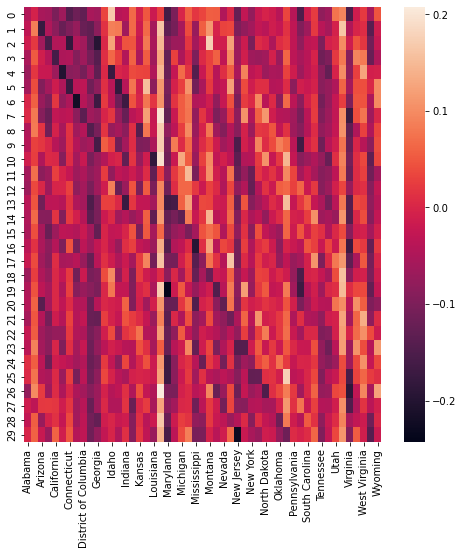

In [101]:
fig,ax = plt.subplots(figsize=(8,8))
sns.heatmap(pd.DataFrame(rslt,columns=states),ax=ax)
fig.savefig('out.png',dpi=300)

In [105]:
import statsmodels.formula.api as smf
df
print(smf.ols('inc_case ~ workplaces_percent_change_from_baseline',data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:               inc_case   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     70.62
Date:                Wed, 18 Jan 2023   Prob (F-statistic):           4.46e-17
Time:                        21:32:10   Log-Likelihood:            -4.7193e+05
No. Observations:               46716   AIC:                         9.439e+05
Df Residuals:                   46714   BIC:                         9.439e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

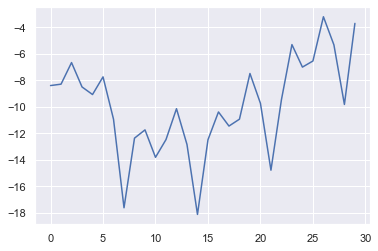

In [118]:
rslt2 = []
for i in range(30):
    curr_df = df.copy()
    curr_df[f'workplaces_percent_change_from_baseline_{i}'] = curr_df.groupby(['sub_region_1'])['workplaces_percent_change_from_baseline'].shift(i)
    p_val = smf.ols(f'inc_case ~ workplaces_percent_change_from_baseline_{i}',data=curr_df).fit().tvalues[1]
    rslt2.append(p_val)


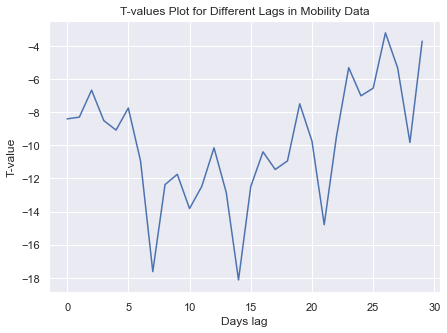

In [129]:
fig,ax = plt.subplots(figsize=(7,5))
plt.plot(rslt2)
ax.set_xlabel('Days lag')
ax.set_ylabel('T-value')
ax.set_title("T-values Plot for Different Lags in Mobility Data")
fig.savefig('out2.png',dpi=300)